In [ ]:
!kaggle datasets download -d marqui"s03/bdd100k"

Dataset URL: https://www.kaggle.com/datasets/marquis03/bdd100k
License(s): apache-2.0
100% 5.38G/5.38G [01:08<00:00, 130MB/s]
100% 5.38G/5.38G [01:08<00:00, 84.1MB/s]


In [ ]:
import zipfile
with zipfile.ZipFile('/content/bdd100k.zip', 'r') as zip_ref:
    zip_ref.extractall()


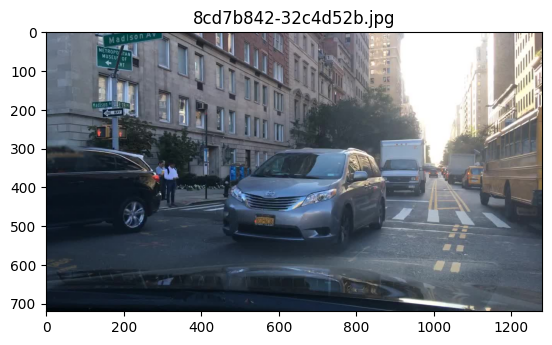

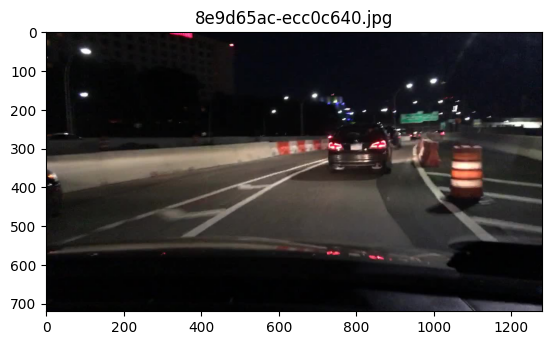

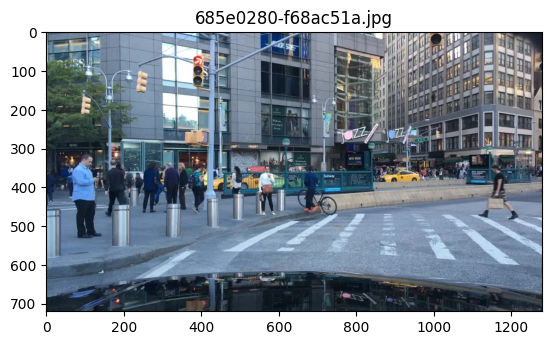

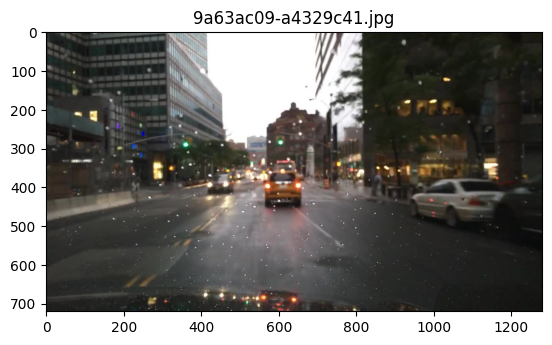

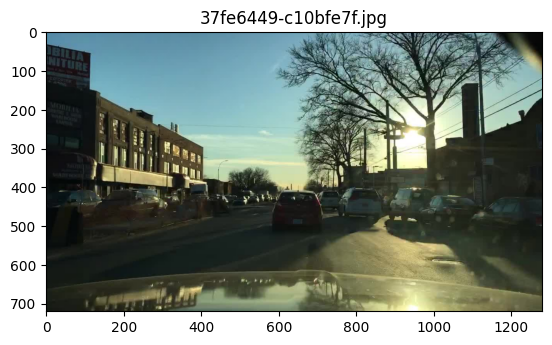

In [ ]:
import os
import matplotlib.pyplot as plt

# Replace 'path/to/your/images/directory' with the actual path to your images directory
image_dir = '/content/train/images'

# Get a list of image files
image_files = [f for f in os.listdir(image_dir) if f.endswith('.jpg')]  # Assuming JPG format

# Display the first few images
for i in range(5):  # Display the first 5 images
    image_path = os.path.join(image_dir, image_files[i])
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.title(image_files[i])
    plt.show()

In [ ]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoProcessor
from PIL import Image
import random


model_name = "google/vit-base-patch16-224-in21k"


processor = AutoProcessor.from_pretrained(model_name)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [ ]:
import torch
from torch.utils.data import DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchvision import transforms
from transformers import AutoModel, AutoImageProcessor
import pandas as pd
from PIL import Image
import os
import numpy as np

class LearnableSimilarityMLP(nn.Module):
    def __init__(self):
        super(LearnableSimilarityMLP, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(768 * 2, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.6),  # Increased dropout
            nn.Linear(512, 1)
        )

    def forward(self, features1, features2):
        concatenated_features = torch.cat((features1, features2), dim=-1)
        similarity_score = self.mlp(concatenated_features)
        return similarity_score

class ViTDistanceModel(nn.Module):
    def __init__(self, model_name):
        super(ViTDistanceModel, self).__init__()
        self.vit = AutoModel.from_pretrained(model_name)
        self.similarity_model = LearnableSimilarityMLP()

    def forward(self, img1, img2):
        features1 = self.vit(pixel_values=img1).last_hidden_state[:, 0, :]
        features2 = self.vit(pixel_values=img2).last_hidden_state[:, 0, :]
        similarity_score = self.similarity_model(features1, features2)
        return similarity_score

class ImagePairDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, image_dir, transform):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img1_path = os.path.join(self.image_dir, row['Image 1'])
        img2_path = os.path.join(self.image_dir, row['Image 2'])
        similarity_score = row['Similarity']

        if not os.path.exists(img1_path) or not os.path.exists(img2_path):
            raise FileNotFoundError(f"Image not found: {img1_path} or {img2_path}")

        img1 = Image.open(img1_path).convert("RGB")
        img2 = Image.open(img2_path).convert("RGB")

        img1 = self.transform(img1)
        img2 = self.transform(img2)

        return {
            "input_ids_1": img1,
            "input_ids_2": img2,
            "similarity_score": torch.tensor(similarity_score, dtype=torch.float32),
        }

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None or val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'google/vit-base-patch16-224-in21k'
image_processor = AutoImageProcessor.from_pretrained(model_name)

# Model instantiation
model = ViTDistanceModel(model_name).to(device)

# File paths
train_csv = '/content/train_results.csv'
val_csv = '/content/validation_results.csv'
test_csv = '/content/test_results.csv'
train_image_dir = '/content/train/images'
val_image_dir = '/content/val/images'
test_image_dir = '/content/test/images'


transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

train_dataset = ImagePairDataset(train_csv, train_image_dir, transform)
val_dataset = ImagePairDataset(val_csv, val_image_dir, transform)
test_dataset = ImagePairDataset(test_csv, test_image_dir, transform)

# Subsetting datasets
train_subset_size = 5000
val_subset_size = 1000
test_subset_size = 500  # Set the test subset size

train_indices = np.random.choice(len(train_dataset), train_subset_size, replace=False)
val_indices = np.random.choice(len(val_dataset), val_subset_size, replace=False)
test_indices = np.random.choice(len(test_dataset), test_subset_size, replace=False)

train_subset = Subset(train_dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(test_dataset, test_indices)

train_loader = DataLoader(train_subset, batch_size=20, shuffle=True)  # Increased batch size to 20
val_loader = DataLoader(val_subset, batch_size=20, shuffle=False)  # Increased batch size to 20
test_loader = DataLoader(test_subset, batch_size=20, shuffle=False)  # Added test loader

# Training setup
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2)  # Increased weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, verbose=True)
early_stopping = EarlyStopping(patience=5, min_delta=1e-4)

# Training loop
epochs = 25
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        input_ids_1 = batch["input_ids_1"].to(device)
        input_ids_2 = batch["input_ids_2"].to(device)
        distances = batch["similarity_score"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids_1, input_ids_2)

        loss = criterion(outputs.squeeze(), distances)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_train_loss = train_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {avg_train_loss:.4f}")

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            input_ids_1 = batch["input_ids_1"].to(device)
            input_ids_2 = batch["input_ids_2"].to(device)
            distances = batch["similarity_score"].to(device)

            val_loss += criterion(model(input_ids_1, input_ids_2).squeeze(), distances).item()

    avg_val_loss = val_loss / len(val_loader)
    print(f"Epoch [{epoch+1}/{epochs}], Validation Loss: {avg_val_loss:.4f}")

    scheduler.step(avg_val_loss)
    early_stopping(avg_val_loss)
    if early_stopping.early_stop:
        print(f"Early stopping triggered at epoch {epoch+1}")
        break

# Test evaluation (optional)
model.eval()
test_loss = 0.0
with torch.no_grad():
    for batch in test_loader:
        input_ids_1 = batch["input_ids_1"].to(device)
        input_ids_2 = batch["input_ids_2"].to(device)
        distances = batch["similarity_score"].to(device)

        test_loss += criterion(model(input_ids_1, input_ids_2).squeeze(), distances).item()

avg_test_loss = test_loss / len(test_loader)
print(f"Test Loss: {avg_test_loss:.4f}")


Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Epoch [1/25], Training Loss: 4788.7537
Epoch [1/25], Validation Loss: 4558.4418
Epoch [2/25], Training Loss: 4501.1768
Epoch [2/25], Validation Loss: 4337.0139
Epoch [3/25], Training Loss: 4299.0133
Epoch [3/25], Validation Loss: 4182.0311
Epoch [4/25], Training Loss: 4097.4829
Epoch [4/25], Validation Loss: 3927.6715
Epoch [5/25], Training Loss: 3892.0988
Epoch [5/25], Validation Loss: 3732.4626
Epoch [6/25], Training Loss: 3674.6805
Epoch [6/25], Validation Loss: 3528.6657
Epoch [7/25], Training Loss: 3463.4541
Epoch [7/25], Validation Loss: 3293.7768
Epoch [8/25], Training Loss: 3238.6525
Epoch [8/25], Validation Loss: 3028.3839
Epoch [9/25], Training Loss: 3023.5029
Epoch [9/25], Validation Loss: 2786.2234
Epoch [10/25], Training Loss: 2789.3623
Epoch [10/25], Validation Loss: 2486.1695
Epoch [11/25], Training Loss: 2597.7010
Epoch [11/25], Validation Loss: 2443.0430
Epoch [12/25], Training Loss: 2370.9779
Epoch [12/25], Validation Loss: 2215.8011
Epoch [13/25], Training Loss: 2178

FileNotFoundError: Image not found: /content/test/images/e3e8b0d8-963f3ce7.jpg or /content/test/images/dfc515b2-2bec4426.jpg